In [1]:
#Copyright 2018, Seokjun Bu, Softcomputing LAB all rights reserved.
from keras import backend as K
from keras.utils import np_utils
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.convolutional import Convolution3D, MaxPooling3D, AveragePooling3D
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers import LSTM, TimeDistributed, CuDNNLSTM, Embedding
from keras.layers import Input
from keras.models import Model
from keras.models import load_model
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import itertools
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Handcrafted Function Def.
def wrapped_confusion_matrix(modelInput, feature, label, class_list=["first", "second"], normalize=False, fig_size=(5,5)):
    pred = modelInput.predict(feature)
    cnf_matrix = confusion_matrix(np.argmax(label, axis=1), np.argmax(pred, axis=1))
    np.set_printoptions(precision=2)
    plt.figure(figsize=fig_size) 
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.xticks(np.arange(len(class_list)), class_list, rotation=45)
    plt.yticks(np.arange(len(class_list)), class_list)
    if(normalize):
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    thresh = cnf_matrix.max() / 2.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment='center',
                 color='white' if cnf_matrix[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
def plot_history(model_input, mode='loss', val_mode=True, title='Entropy'):
    history = model_input.history
    if(val_mode):
        plt.plot(history.history[mode])
        plt.plot(history.history['val_'+mode])
        plt.title(title)
        plt.legend(['train', 'test'], loc='upper right')
        plt.show()
    else:
        plt.plot(history.history[mode])
        plt.title(title)
        plt.legend(['train'], loc='upper right')
        plt.show()
        

In [3]:
x_train = np.load('./test/X_train.npy')
x_test = np.load('./test/X_test.npy')
y_train = np.load('./test/Y_train.npy')
y_test = np.load('./test/Y_test.npy')
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(3000, 64, 64, 3) (3000, 3)
(1000, 64, 64, 3) (1000, 3)


In [4]:
# CNN
model_input = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))

h = Convolution2D(16, kernel_size=(2,2), padding='same', activation='relu')(model_input)
h = MaxPooling2D((2,2))(h)
h = Convolution2D(16, kernel_size=(2,2), padding='same', activation='relu')(h)
h = MaxPooling2D((2,2))(h)
h = Convolution2D(16, kernel_size=(2,2), padding='same', activation='relu')(h)
h = MaxPooling2D((2,2))(h)

h = Flatten()(h)

h = Dense(512, activation='relu')(h)
h = Dense(256, activation='relu')(h)
model_output = Dense(y_train.shape[1], activation='softmax')(h)
model_cnn = Model(model_input, model_output)
model_cnn.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 16)        1040      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 16)        1040      
_________________________________________________________________
max_

In [5]:
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model_history = model_cnn.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=500, verbose=2, shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 3000 samples, validate on 1000 samples
Epoch 1/20
 - 14s - loss: 0.9934 - acc: 0.4440 - val_loss: 0.9321 - val_acc: 0.5170
Epoch 2/20
 - 13s - loss: 0.9497 - acc: 0.5220 - val_loss: 0.9433 - val_acc: 0.5170
Epoch 3/20
 - 13s - loss: 0.9395 - acc: 0.5280 - val_loss: 0.9315 - val_acc: 0.5180
Epoch 4/20
 - 13s - loss: 0.9360 - acc: 0.5290 - val_loss: 0.9188 - val_acc: 0.5320
Epoch 5/20
 - 13s - loss: 0.9069 - acc: 0.5690 - val_loss: 0.8910 - val_acc: 0.5730
Epoch 6/20
 - 13s - loss: 0.8825 - acc: 0.6007 - val_loss: 0.8708 - val_acc: 0.5960
Epoch 7/20
 - 13s - loss: 0.8603 - acc: 0.6093 - val_loss: 0.8463 - val_acc: 0.6020
Epoch 8/20
 - 13s - loss: 0.8300 - acc: 0.6223 - val_loss: 0.8422 - val_acc: 0.6170
Epoch 9/20
 - 14s - loss: 0.8093 - acc: 0.6333 - val_loss: 0.8248 - val_acc: 0.6410
Epoch 10/20
 - 13s - loss: 0.7865 - acc: 0.6510 - val_loss: 0.8068 - val_acc: 0.6420
Epoch 11/20
 - 14s - loss: 0.7661 - acc: 0.6657 - val_loss: 0.7

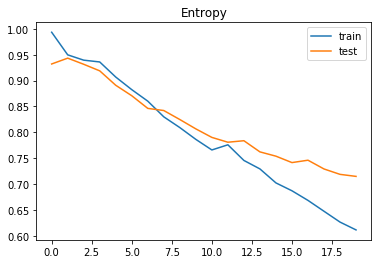

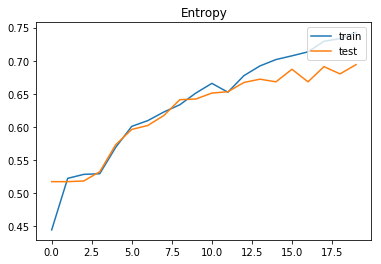

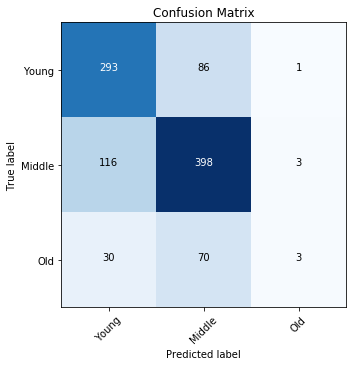

In [7]:
plot_history(model_cnn, mode='loss')
plot_history(model_cnn, mode='acc')
wrapped_confusion_matrix(model_cnn, x_test, y_test, ['Young','Middle','Old'])

In [25]:
# LSTM
model_input = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
h = Reshape((64,64,3))(model_input)
h = LSTM(128, input_shape=(64,64), activation='relu')(h)
model_output = Dense(y_train.shape[1], activation='softmax')(h)

model_lstm = Model(model_input, model_output)
model_lstm.summary()

model_lstm.compile(loss='kullback_leibler_divergence', optimizer='adam', metrics=['acc'])
model_history = model_lstm.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=500, verbose=2)

ValueError: Input 0 is incompatible with layer lstm_10: expected ndim=3, found ndim=4